In [15]:
import pandas as pd
import xarray as xr
import numpy as np
import os

def process_co2_data(file, output_filename="co2_daily.nc"):
    """
    Reads CO2 daily data from a file, converts it to an xarray Dataset,
    and saves it as a NetCDF file.

    Args:
        file (str): The path to the co2_daily_mlo.txt data file.
        output_filename (str): The name of the output NetCDF file.
    """
    print(f"Attempting to read data from: {file}")
    
    try:
        # Read the data using pandas.
        # - `comment='#'` skips lines starting with '#' (header/metadata).
        # - `delim_whitespace=True` handles arbitrary whitespace as a separator.
        # - `header=None` because the actual column names are in a comment line,
        #   and we'll define them manually.
        # - `na_values=-999.99` handles the specific missing data indicator.
        df = pd.read_csv(file, comment='#', delim_whitespace=True, header=None, na_values=-999.99)

        # Define column names based on the file's description
        column_names = ['year', 'month', 'day', 'decimal_date', 'co2']
        df.columns = column_names

        print("Data successfully loaded into pandas DataFrame.")
        print("First 5 rows:")
        print(df.head())
        print("\nDataFrame Info:")
        df.info()

        # Create a datetime index from year, month, day columns
        df['time'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')

        # Drop rows where time could not be parsed (if any) or where CO2 value is NaN
        df.dropna(subset=['time', 'co2'], inplace=True)

        if df.empty:
            print("No valid data rows found after parsing and dropping NaNs. Exiting.")
            return

        # Set 'time' as the index
        df.set_index('time', inplace=True)

        full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
        
        # Reindex the DataFrame to this full date range.
        df_reindexed = df.reindex(full_date_range)
        
        # Interpolate missing values (NaNs) using linear interpolation
        df_filled = df_reindexed.interpolate(method='linear')

        # Create xarray DataArray for CO2 value
        co2_da = xr.DataArray(
            df_filled['co2'],
            coords={'time': df_filled.index},
            dims=['time'],
            name='co2_concentration',
            attrs={
                'long_name': 'Daily Average CO2 Concentration',
                'units': 'ppm (parts per million)',
                'description': 'Daily average atmospheric carbon dioxide concentration from Mauna Loa, Hawaii.'
            }
        )

        # Create xarray Dataset
        ds = xr.Dataset(
            {'co2': co2_da},
            coords={'time': df_filled.index},
            attrs={
                'title': 'Daily Average Atmospheric CO2 Concentration from Mauna Loa, Hawaii',
                'source': 'NOAA Global Monitoring Laboratory (GML)',
                'history': f'Created by Python script on {pd.Timestamp.now().isoformat()}'
            }
        )

        print("\nxarray Dataset created successfully:")
        print(ds)

        # Save to NetCDF
        ds.to_netcdf(output_filename)
        print(f"\nData successfully saved to {output_filename}")

    except Exception as e:
        print(f"An error occurred: {e}")

    return ds

In [16]:

co2_file = "/scratch/cimes/feiyul/Ocean_Data/obs_data/co2_daily_mlo.txt"
co2_output = "/scratch/cimes/feiyul/Ocean_Data/obs_data/co2_daily.nc"
co2_ds=process_co2_data(co2_file,output_filename=co2_output)


Attempting to read data from: /scratch/cimes/feiyul/Ocean_Data/obs_data/co2_daily_mlo.txt
Data successfully loaded into pandas DataFrame.
First 5 rows:
   year  month  day  decimal_date     co2
0  1974      5   19     1974.3781  333.46
1  1974      5   20     1974.3808  333.64
2  1974      5   21     1974.3836  333.50
3  1974      5   22     1974.3863  333.21
4  1974      5   23     1974.3890  333.05

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15685 entries, 0 to 15684
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          15685 non-null  int64  
 1   month         15685 non-null  int64  
 2   day           15685 non-null  int64  
 3   decimal_date  15685 non-null  float64
 4   co2           15685 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 612.8 KB

xarray Dataset created successfully:
<xarray.Dataset>
Dimensions:  (time: 18682)
Coordinates:
  * time     (time) dat

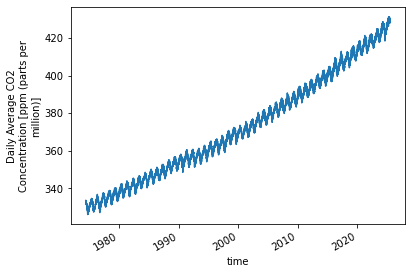

In [17]:
co2_ds['co2'].plot()